# Analysis of intrinsic results: GeoDanmark

In [6]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pickle
import json
import pandas as pd
import seaborn as sns
import plotly.express as px

%run ../settings/yaml_variables.py
%run ../settings/df_styler.py
%run ../settings/plotting.py
%run ../settings/load_refdata.py

<string>:49: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
/Users/anev/Library/CloudStorage/Dropbox/ITU/repositories/bikedna_dk_analysis/settings/plotting.py:49: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap_name, n)


Reference data loaded successfully!


In [7]:
# Read intrinsic grid results
with open(
    f"../results/REFERENCE/{study_area}/data/grid_results_intrinsic.pickle", "rb"
) as fp:
    ref_intrinsic_grid = pickle.load(fp)

# Import intrinsic results
ref_intrinsic_file = open(
    f"../results/REFERENCE/{study_area}/data/intrinsic_analysis.json"
)

ref_intrinsic_results = json.load(ref_intrinsic_file)

# Import summary dataframe
summarize_results_df = pd.read_csv(f"../results/REFERENCE/{study_area}/data/intrinsic_summary_results.csv",index_col=0)

summarize_results_df.style.pipe(format_ref_style)

,
Total infrastructure length (km),"8,676"
Protected bicycle infrastructure density (m/km2),92
Unprotected bicycle infrastructure density (m/km2),95
Mixed protection bicycle infrastructure density (m/km2),0
Bicycle infrastructure density (m/km2),187
Nodes,"51,224"
Dangling nodes,"11,218"
Nodes per km2,1
Dangling nodes per km2,0
Overshoots,99


In [8]:
# Read muni data
muni = gpd.read_file("../data/municipalities.gpkg")
muni = muni[['navn','kommunekode','geometry']]
assert muni.crs == study_crs

In [9]:
# Assign municipal name and id to each hex cell based on centroid overlap
ref_intrinsic_grid.dropna(subset='count_ref_edges',inplace=True)

grid_centroids = ref_intrinsic_grid[['geometry','grid_id','count_ref_edges']].copy()
grid_centroids['geometry'] = grid_centroids.geometry.centroid

centroid_join = grid_centroids.sjoin(muni, predicate="intersects", how="inner")
centroid_join.drop('index_right',axis=1,inplace=True)

non_joined_centroid = grid_centroids[grid_centroids.count_ref_edges.notna() & ~grid_centroids.grid_id.isin(centroid_join.grid_id)] #drop(['navn','kommunekode'],axis=1)

centroid_join_2 = non_joined_centroid.sjoin_nearest(muni, how="left",distance_col='dist')

assert len(centroid_join_2) + len(centroid_join) == len(ref_intrinsic_grid)

joined_int_grid = pd.concat([centroid_join_2,centroid_join])

assert len(joined_int_grid) == len(ref_intrinsic_grid)

int_grid = ref_intrinsic_grid.merge(joined_int_grid[['grid_id','navn','kommunekode']],left_on='grid_id',right_on='grid_id')
assert len(int_grid) == len(ref_intrinsic_grid)

In [10]:
# Index nodes and edges by municipality
muni_edges = ref_edges_simplified.sjoin(muni,how="left",predicate="intersects")
muni_edges.drop('index_right',axis=1,inplace=True)

nodes_joined = gpd.sjoin(muni, ref_nodes_simplified, how="right",predicate="contains")
nodes_joined.drop('index_left',axis=1,inplace=True)

nodes_joined_2 = gpd.sjoin_nearest(muni, nodes_joined[nodes_joined.navn.isna()][['nodeID','x','y','geometry']], how='right', distance_col="dist")
nodes_joined_2.drop('index_left',axis=1,inplace=True)
nodes_joined_2.drop_duplicates(subset='nodeID', keep="first",inplace=True)

nodes_joined.dropna(subset='navn',inplace=True)

muni_nodes = pd.concat([nodes_joined,nodes_joined_2])

assert len(muni_nodes) == len(ref_nodes_simplified)
assert len(muni_nodes) == len(muni_nodes.nodeID.unique())
assert len(muni_nodes[muni_nodes.navn.isna()]) == 0
assert len(muni_edges[muni_edges.navn.isna()]) == 0

# Index dangling nodes by muni
dang_joined = gpd.sjoin(muni, ref_dangling, how="right",predicate="contains")
dang_joined.drop('index_left',axis=1,inplace=True)

dang_joined_2 = gpd.sjoin_nearest(muni, dang_joined[dang_joined.navn.isna()][['nodeID','x','y','geometry']], how='right', distance_col="dist")
dang_joined_2.drop('index_left',axis=1,inplace=True)

dang_joined_2.drop_duplicates(subset='nodeID', keep="first",inplace=True)

dang_joined.dropna(subset='navn',inplace=True)

muni_dang = pd.concat([dang_joined,dang_joined_2])

assert len(muni_dang) == len(ref_dangling)
assert len(muni_dang) == len(muni_dang.nodeID.unique())
assert len(muni_dang[muni_dang.navn.isna()]) == 0
assert len(muni_dang[muni_dang.navn.isna()]) == 0

# Group by muni
grouped_edges = muni_edges.groupby("navn") 
grouped_nodes = muni_nodes.groupby("navn")
grouped_dangling = muni_dang.groupby("navn")

# Turn into dataframe
muni_infra = grouped_edges['infrastructure_length'].sum().to_frame()

muni_node_count = grouped_nodes.size().to_frame('node_count') 

muni_dang_count = grouped_dangling.size().to_frame('dangling_node_count') 

muni_network_counts = pd.merge(pd.merge(muni_infra, muni_node_count,left_index=True, right_index=True),muni_dang_count,left_index=True, right_index=True)

assert len(muni_network_counts) == 98


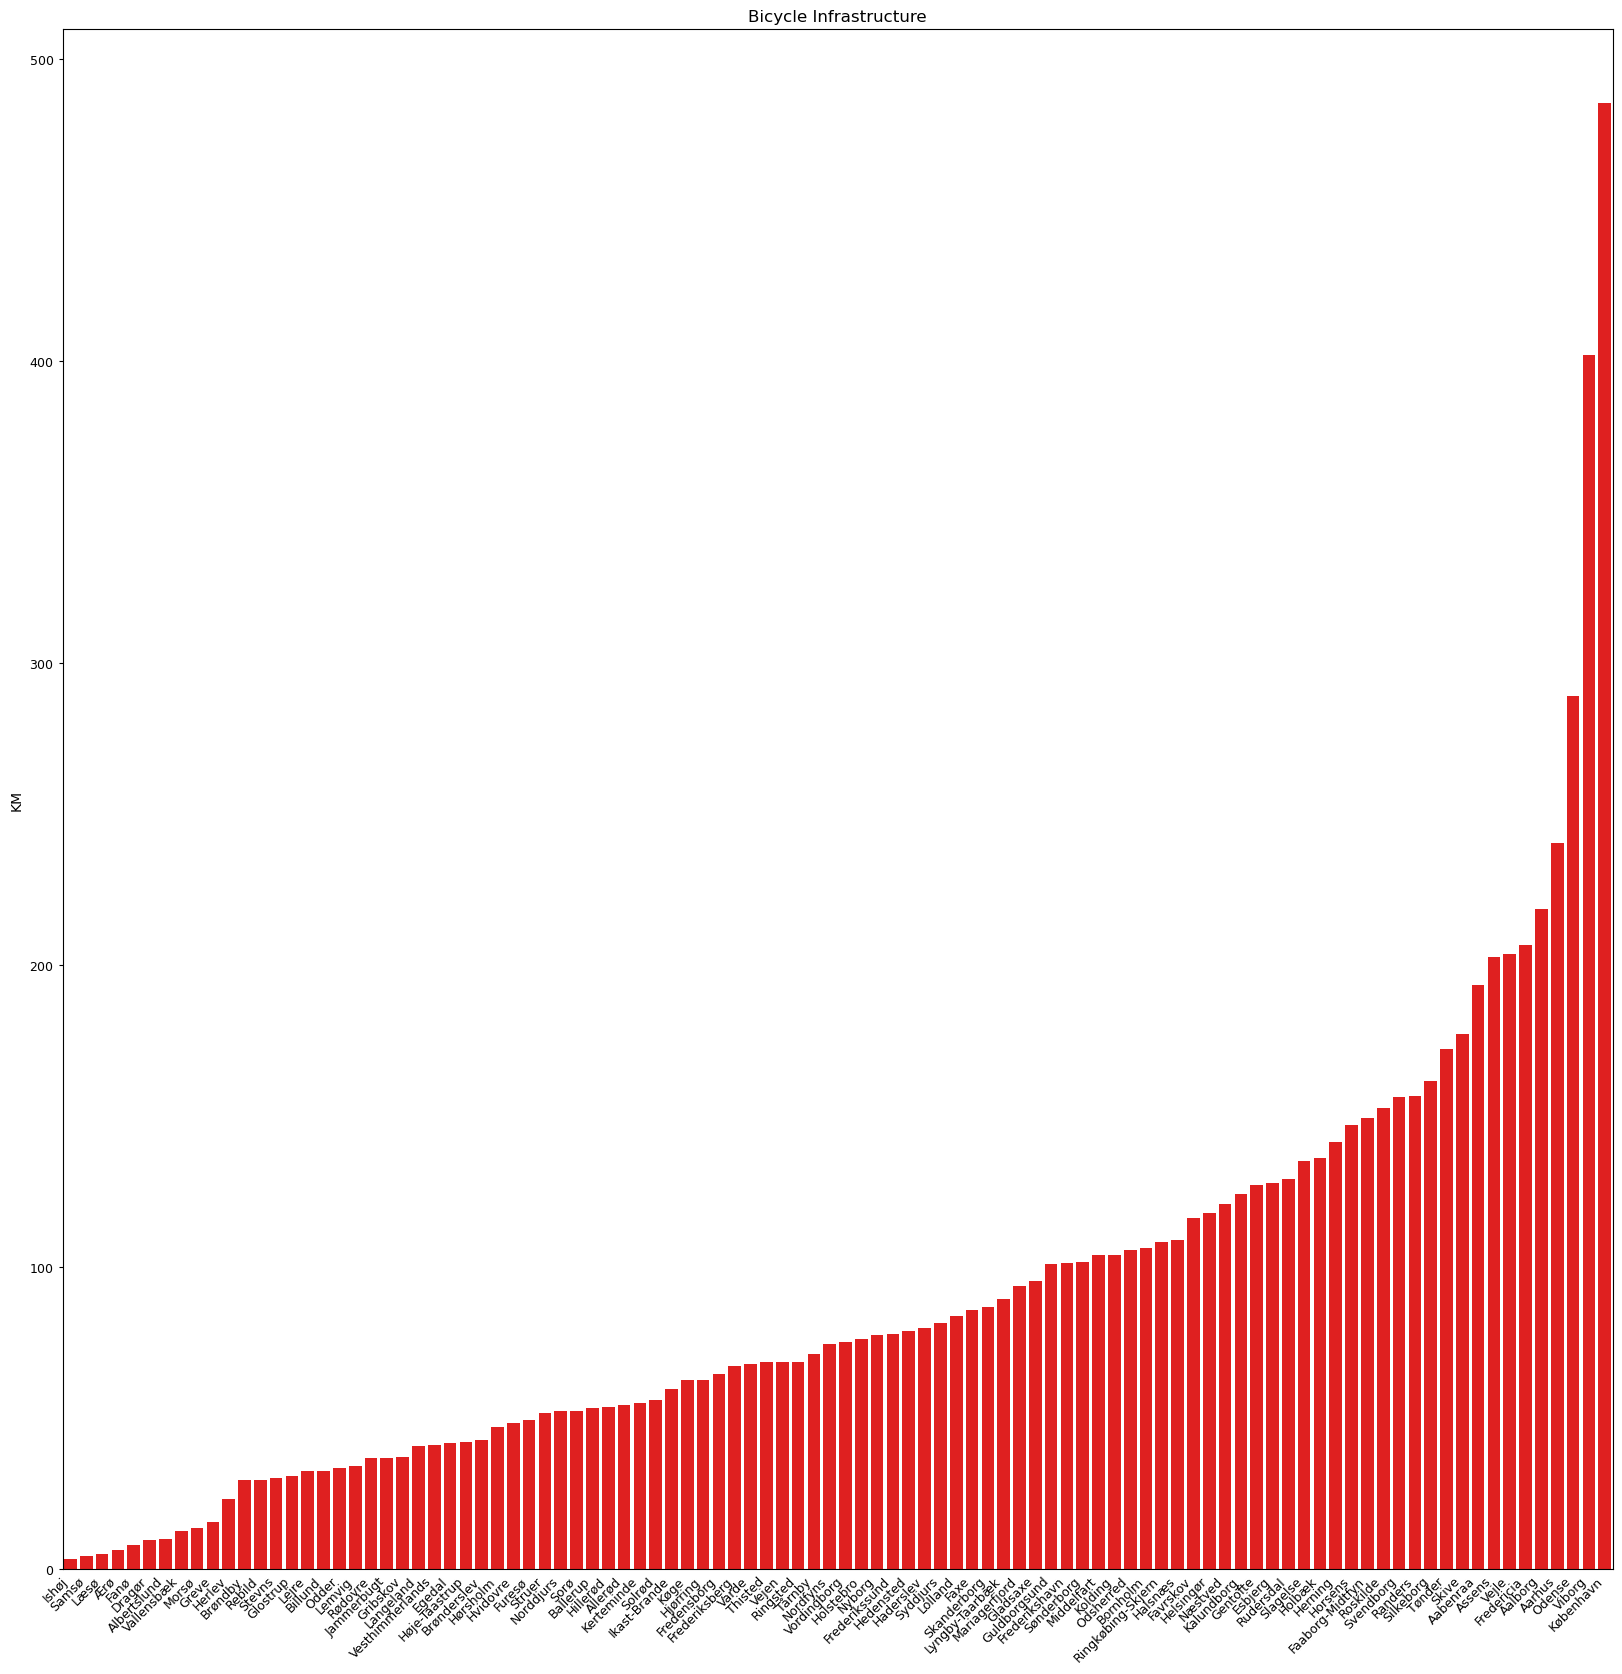

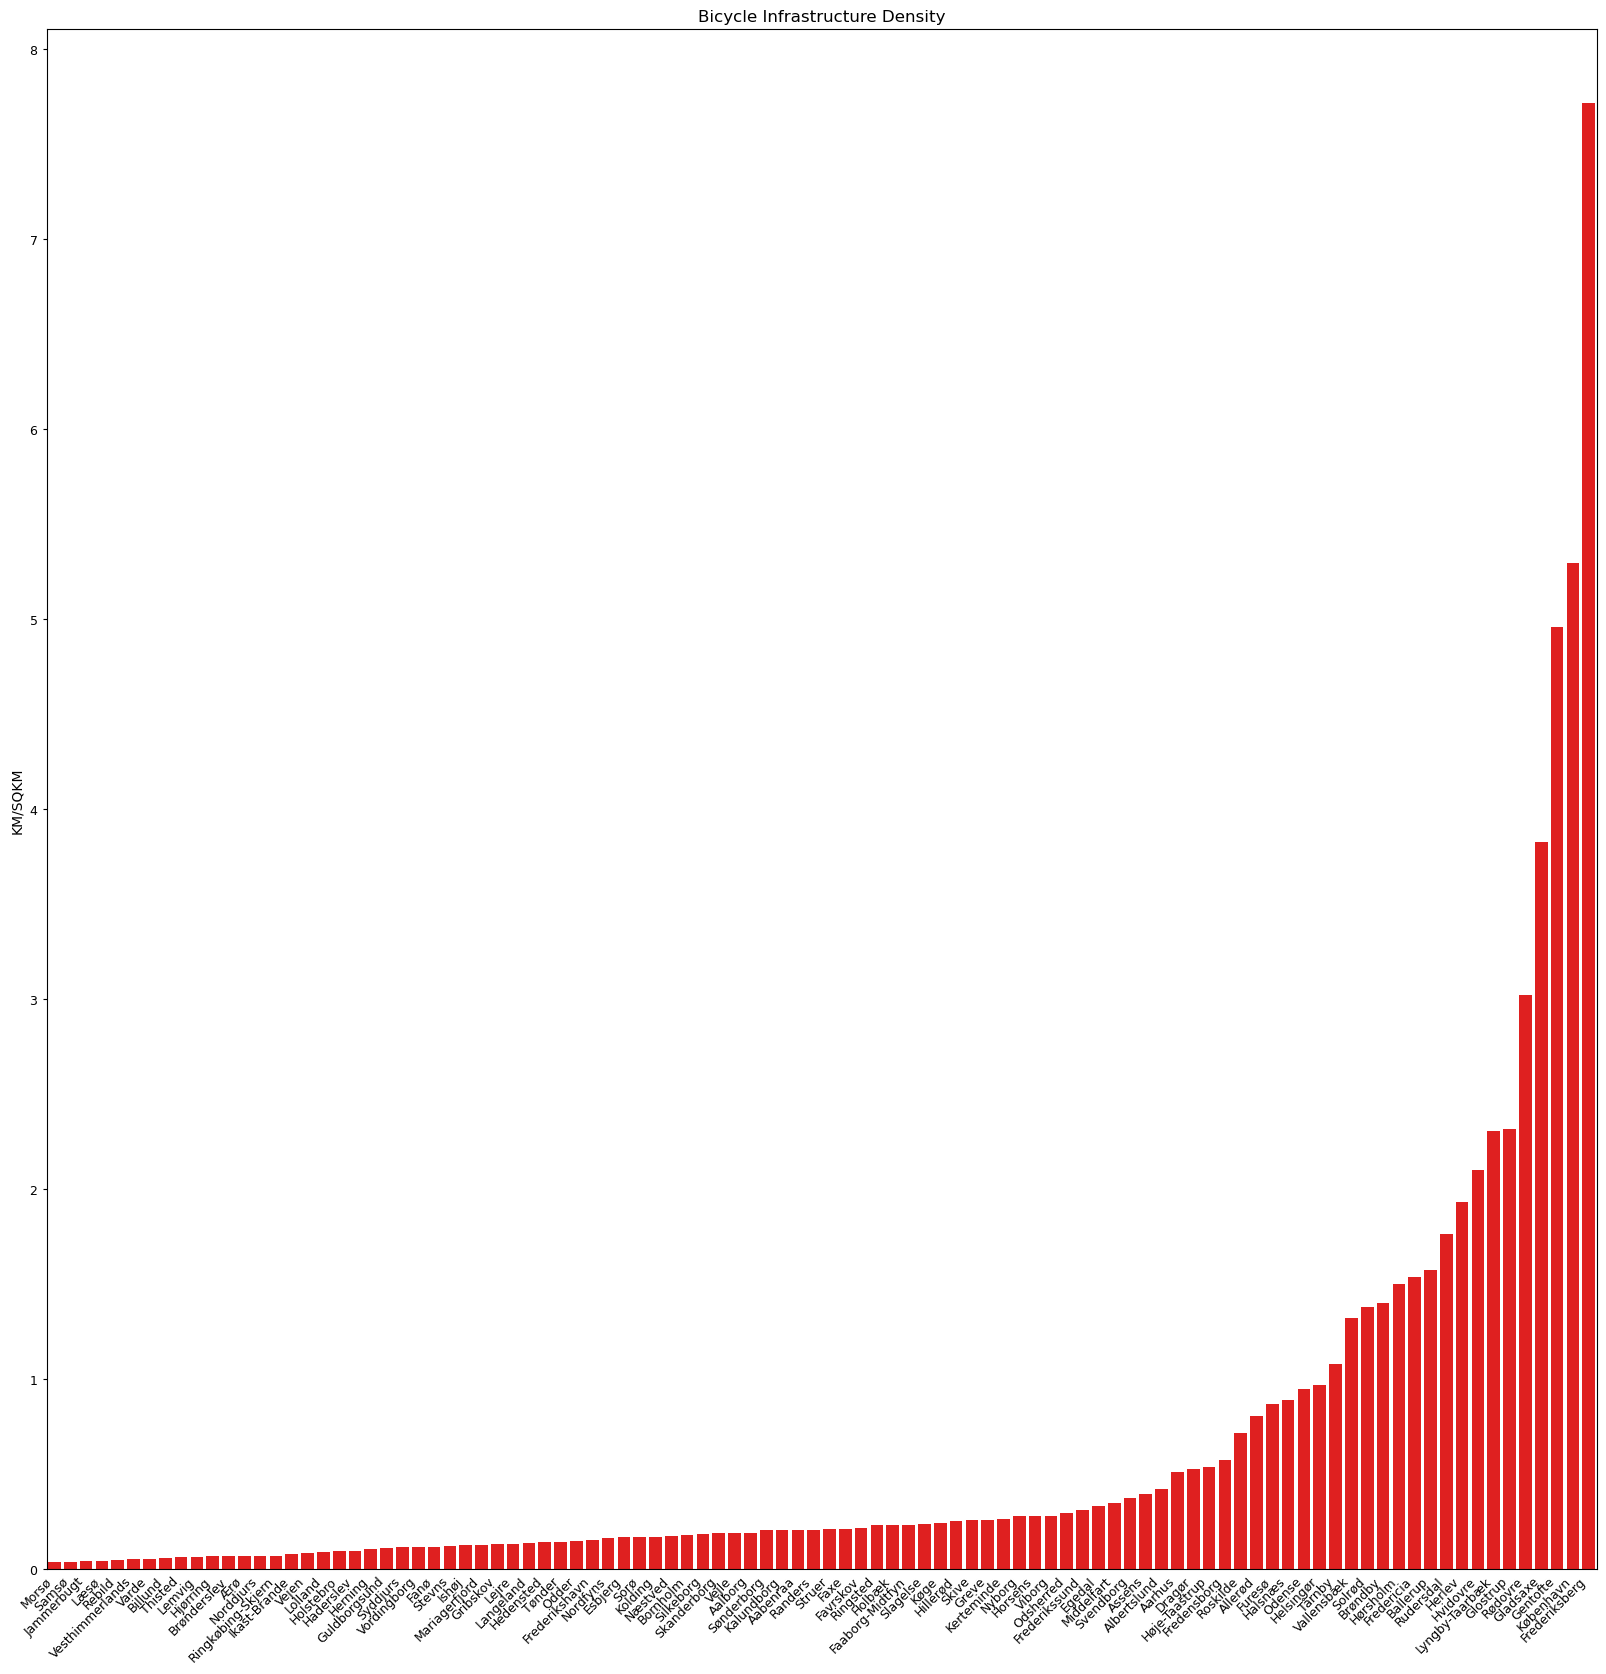

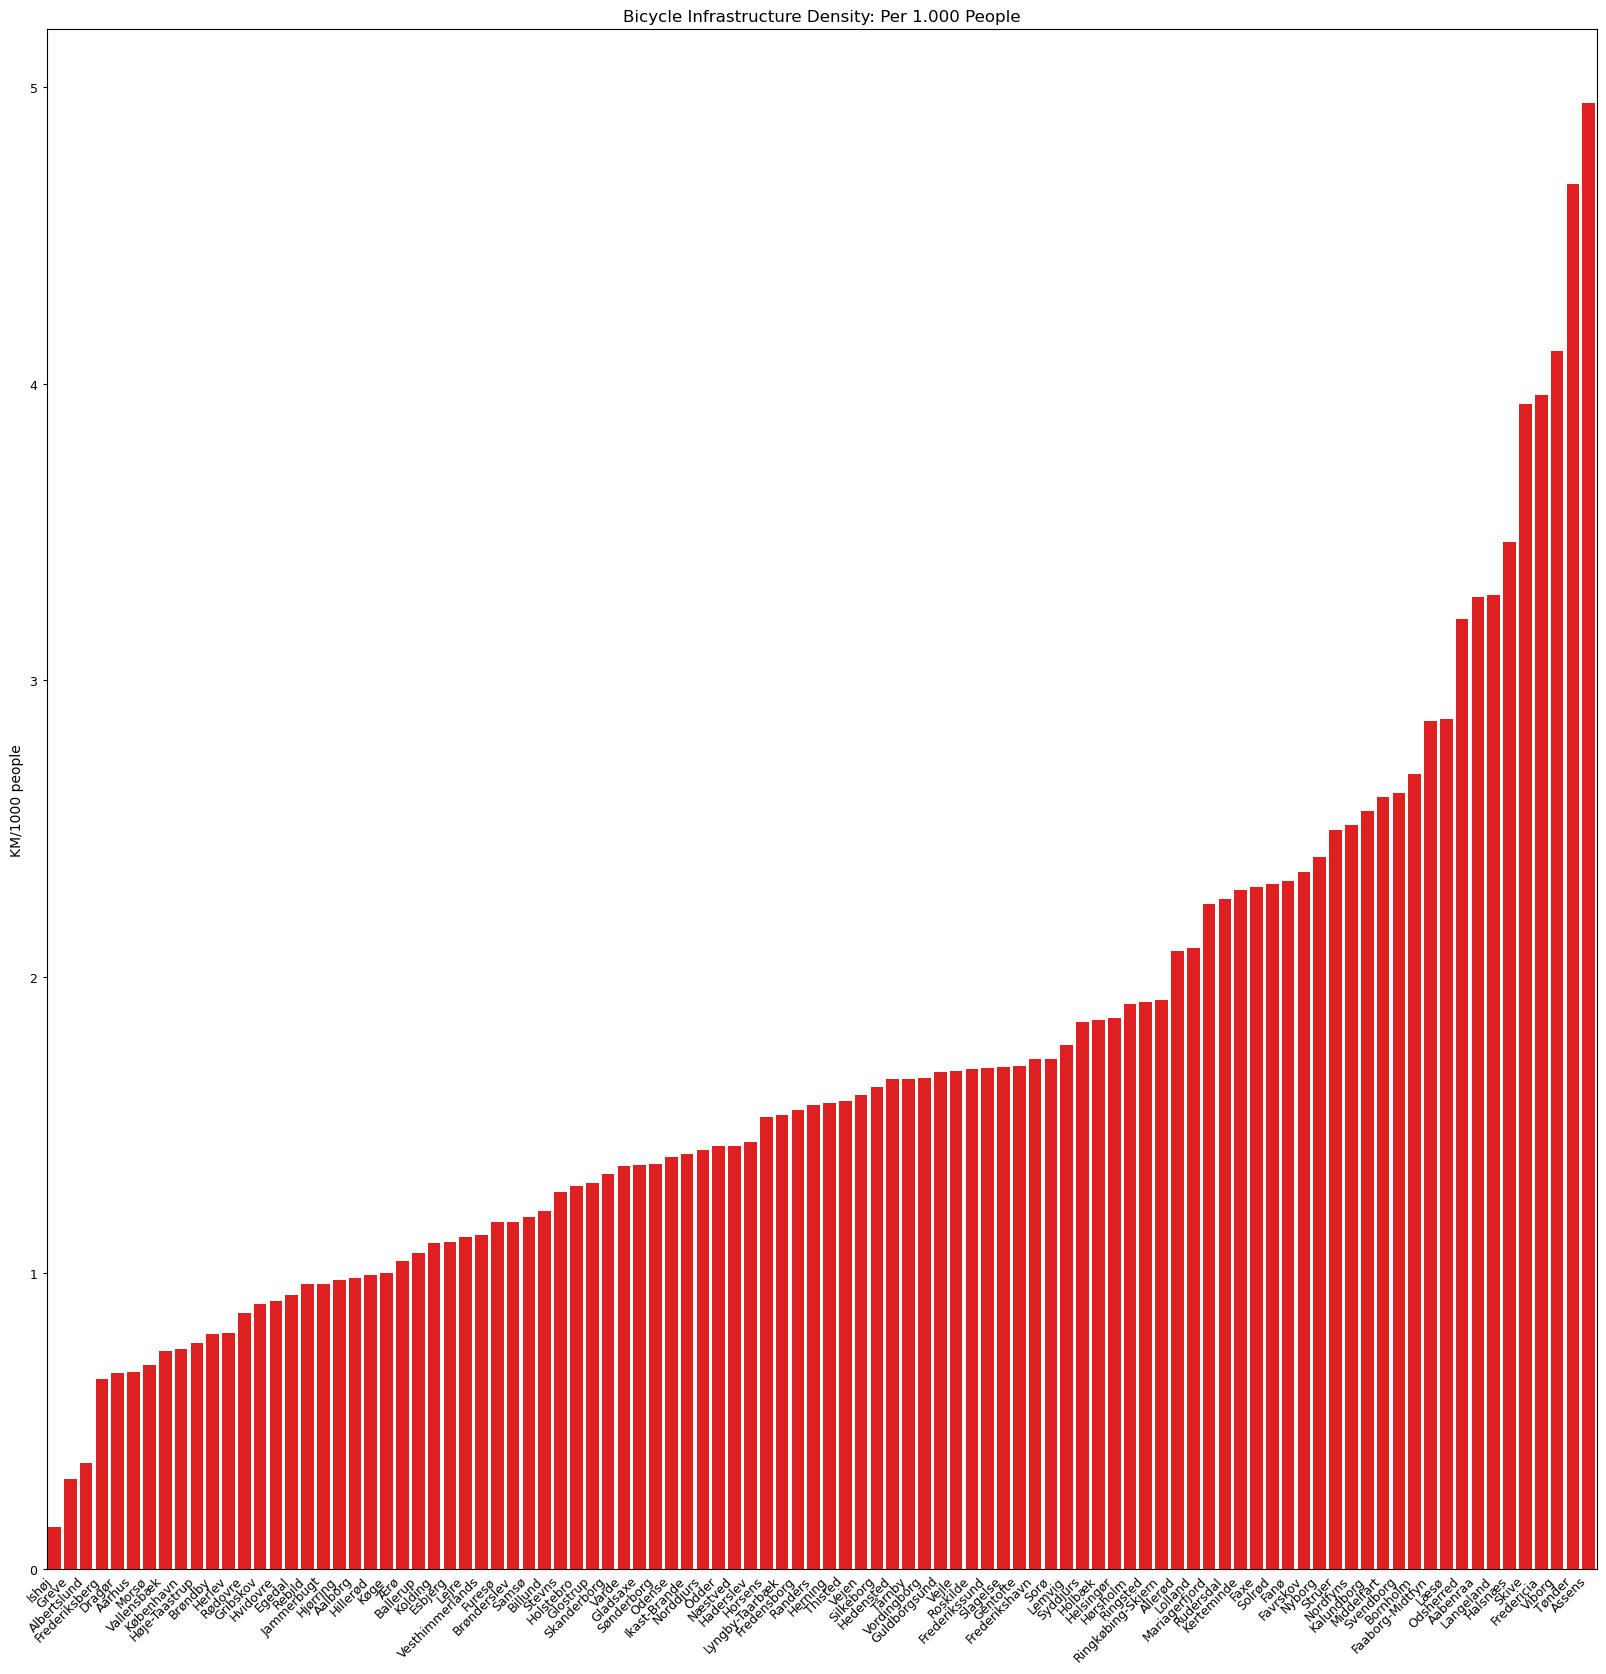

In [11]:
# Plot km of bicycle infra per muni
muni_network_counts['infra_km'] = round(muni_network_counts.infrastructure_length / 1000,3)

fig, ax = plt.subplots(figsize=(20,20))
sns.barplot(muni_network_counts.reset_index().sort_values('infra_km'), x="navn",y='infra_km',ax=ax, color='red')
plt.xticks(rotation = 45, ha = 'right')
plt.xlabel('')
plt.ylabel('KM')
plt.title('Bicycle Infrastructure');

# Plot infra density per muni
muni['area_sqkm'] = round(muni.area / 1000000,2)

muni_network_counts = muni_network_counts.merge(
    muni[['navn','area_sqkm']],left_index=True,right_on='navn'
)

muni_network_counts['infra_dens'] = round(muni_network_counts.infra_km / muni_network_counts.area_sqkm,3)

fig, ax = plt.subplots(figsize=(20,20))
sns.barplot(muni_network_counts.reset_index().sort_values('infra_dens'), x="navn",y='infra_dens',ax=ax, color='red')
plt.xticks(rotation = 45, ha = 'right')
plt.xlabel('')
plt.ylabel('KM/SQKM')
plt.title('Bicycle Infrastructure Density');

# Plot infra per pop
muni_pop = pd.read_csv("../data/muni_pop.csv",encoding="ISO-8859-1",header=None)
muni_pop.rename({1:'navn',2:'pop'},inplace=True,axis=1)

muni_network_counts = muni_network_counts.merge(muni_pop[['navn','pop']],left_on='navn', right_on='navn')
assert len(muni_network_counts) == 98

muni_network_counts['infra_pop'] = muni_network_counts.infra_km / (muni_network_counts['pop'] / 1000)

fig, ax = plt.subplots(figsize=(20,20))
sns.barplot(muni_network_counts.reset_index().sort_values('infra_pop'), x="navn",y='infra_pop',ax=ax, color='red')
plt.xticks(rotation = 45, ha = 'right')
plt.xlabel('')
plt.ylabel('KM/1000 people')
plt.title('Bicycle Infrastructure Density: Per 1.000 People');

In [12]:
# Join over and undershoot to muni
overshoot_edge_ids = pd.read_csv(ref_results_data_fp+"overshoot_edges_3.csv")
undershoot_node_ids = pd.read_csv(ref_results_data_fp+"undershoot_nodes_3.csv")

undershoots = ref_nodes_simplified[ref_nodes_simplified.nodeID.isin(undershoot_node_ids.node_id)]
assert len(undershoot_node_ids) == len(undershoots)

overshoots = ref_edges_simplified[ref_edges_simplified.edge_id.isin(overshoot_edge_ids.edge_id)]
assert len(overshoot_edge_ids) == len(overshoots)

# Join to muni
over_muni = overshoots[['edge_id','geometry']].sjoin(muni,how='left',predicate='intersects')

under_muni = undershoots[['nodeID','geometry']].sjoin(muni,how='left', predicate='intersects')

assert len(over_muni) == len(overshoots)
assert len(under_muni) == len(undershoots)

# Group by muni and count
over_df = over_muni.groupby('navn').size().to_frame('overshoots')

under_df = under_muni.groupby('navn').size().to_frame('undershoots')

# Combine with muni_network
muni_network_counts = pd.merge(muni_network_counts, over_df,left_on='navn', right_on='navn', how='left')
assert len(muni_network_counts) == 98

muni_network_counts = pd.merge(muni_network_counts, under_df,left_on='navn', right_on='navn', how='left')
assert len(muni_network_counts) == 98

muni_network_counts['over_under'] = muni_network_counts.overshoots + muni_network_counts.undershoots
muni_network_counts['over_under'].fillna(0,inplace=True)

In [13]:
# TODO: Add label for high/low density and add as color?
fig = px.scatter(
    muni_network_counts, 
    x='infra_km', 
    y='over_under',
    title='Correlation between infrastructure length and topology errors', 
    hover_data=['navn'],
    labels={
        "infra_km": "Length of bicycle infrastructure (KM)",
        "over_under": "Over and undershoots",
        "navn": "Municipality"
        })

fig.update_layout(
    font=dict(
        size=10,
        color="RebeccaPurple"
    )
)
fig.show()


In [14]:
# Join over and undershoots to grid ids
overshoots_grid = overshoots[['edge_id','geometry']].sjoin(int_grid,how='left').drop_duplicates(subset='edge_id',keep="first")[['grid_id']].reset_index(drop=True)
undershoots_grid = undershoots[['nodeID','geometry']].sjoin(int_grid,how='left').drop_duplicates(subset='nodeID',keep="first")[['grid_id']].reset_index(drop=True)

over_grid_grouped = overshoots_grid.groupby('grid_id').size().to_frame('overshoots_count')
under_grid_grouped = undershoots_grid.groupby('grid_id').size().to_frame('undershoots_count')

int_grid_org_len = len(int_grid)

int_grid = int_grid.merge(over_grid_grouped, left_on='grid_id',right_on='grid_id',how='left')
assert len(int_grid) == int_grid_org_len

int_grid = int_grid.merge(under_grid_grouped, left_on='grid_id',right_on='grid_id',how='left')
assert len(int_grid) == int_grid_org_len

muni_grid = int_grid.groupby('navn')

muni_components = {}

for name, group in muni_grid:
    nested_list = group.component_ids_ref.to_list()
    flat_list = list(set([item for sublist in nested_list for item in sublist]))

    muni_components[name] = len(flat_list)

muni_comp_df = pd.DataFrame.from_dict(muni_components,orient='index',columns=['component_count']).reset_index().rename({'index':'navn'},axis=1)
assert len(muni_comp_df) == 98

muni_network_counts = muni_network_counts.merge(muni_comp_df, left_on='navn', right_on='navn', how='left')
assert len(muni_network_counts) == 98


# Export
assert len(muni_network_counts) == 98
muni_network_counts.to_csv("../results/geodk_quality/muni_network_counts.csv", index=True)

In [15]:
# Plot correlation between infrastructure length and no of componentsß
fig = px.scatter(
    muni_network_counts, 
    x='infra_km', 
    y='component_count',
    title='Correlation between infrastructure length and number of components', 
    hover_data=['navn'],
    color="area_sqkm",
    color_continuous_scale='viridis_r',
    labels={
        "infra_km": "Length of bicycle infrastructure (km)",
        "component_count": "Number of disconnected components",
        "navn": "Municipality",
        "area_sqkm": "Size (sqkm)",
        })

fig.update_layout(
    font=dict(
        size=10,
        color="RebeccaPurple"
    )
)
fig.show()

In [16]:
# Plot correlation between municipality size and no of componentsß
fig = px.scatter(
    muni_network_counts, 
    x='area_sqkm', 
    y='component_count',
    color="infra_km",
    title='Correlation between municipality size and number of components', 
    hover_data=['navn'],
    color_continuous_scale='viridis_r',
    labels={
        "area_sqkm": "Size (sqkm)",
        "infra_km": "Length (km)",
        "component_count": "Number of disconnected components",
        "navn": "Municipality"
        })

fig.update_layout(
    font=dict(
        size=12,
        color="RebeccaPurple"
    )
)
fig.show()

In [17]:
# Plot correlation between density and number of components
fig = px.scatter(
    muni_network_counts, 
    x='infra_dens', 
    y='component_count',
    #color="infra_km",
    title='Correlation between infrastructure density and number of components', 
    hover_data=['navn'],
    #color_continuous_scale='viridis_r',
    labels={
        # "area_sqkm": "Size (sqkm)",
        # "infra_km": "Length (km)",
        "infra_dens": "Infrastructure density",
        "component_count": "Number of disconnected components",
        "navn": "Municipality"
        })

fig.update_layout(
    font=dict(
        size=12,
        color="RebeccaPurple"
    )
)
fig.show()


<Axes: >

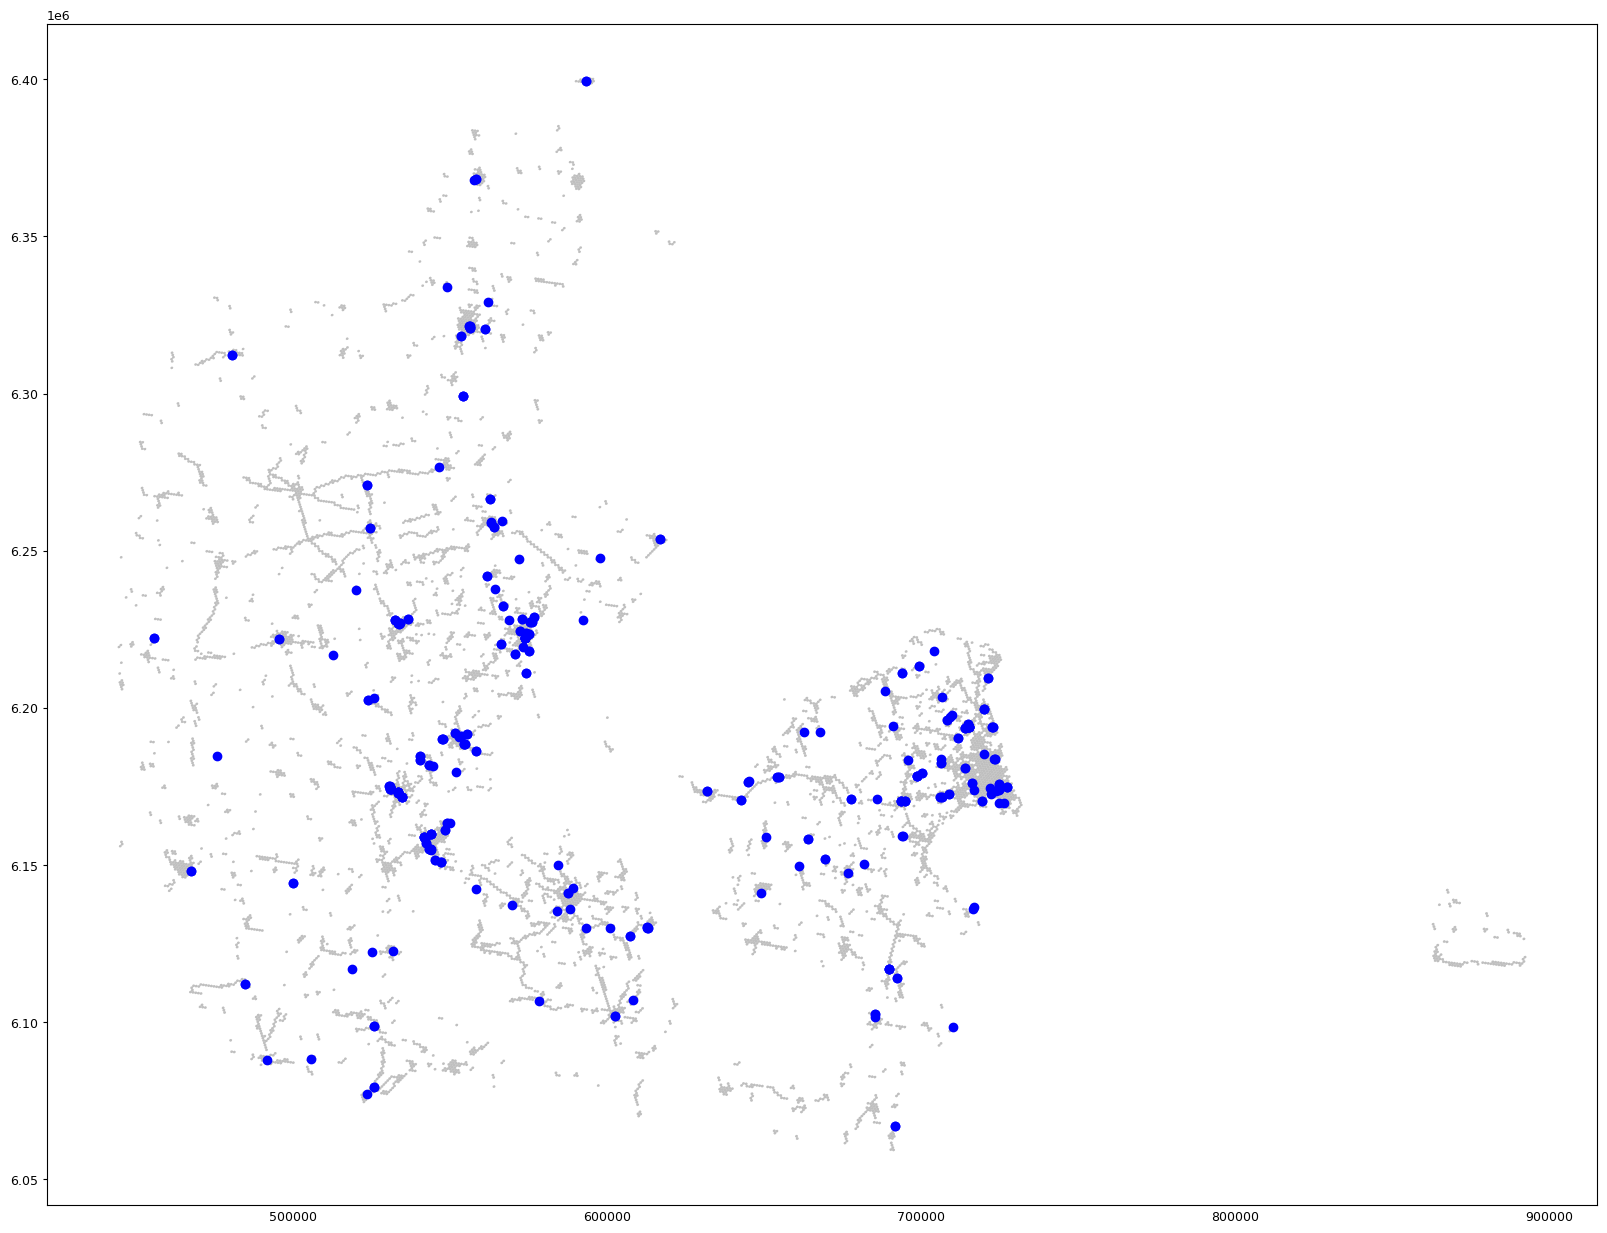

In [18]:
fig, ax = plt.subplots(figsize=(20,20))

int_grid.plot(ax=ax,alpha=0.5,color='grey')
# overshoots_cent = overshoots.copy()
# overshoots_cent['geometry'] = overshoots.centroid
# overshoots_cent.plot(ax=ax,color='red')
undershoots.plot(ax=ax,color='blue')


## CONCLUSIONS SO FAR:

- no clear correlation between number of over/under and infra length
- some correlation between number of components and length - but not clear cut
- low density muni tend to have more components - not clear cut - makes sense
- Aarhus has many components per length and size - and many undershoots!
